# Overview of notebook
This notebook solves the model of Krusell and Smith (1998)

The solution strategy is as follows

1. Solve individual problem by value function iteration (VFI) with 2D interpolation
    - Agents are boundedly rational. In the code, they take into account the information about the mean of capital
    - Aggregate law of motion is approximated by log-linear relation, i.e. $\log(K_{t+1})=B1+B2\log(K_{t})$ for good aggregate state and $\log(K_{t+1})=B3+B4\log(K_{t})$ for bad aggregate state 
    - If specified, Howard's policy iteration is used
1. Compute the path of aggregate capital using the policy function obtained by VFI
    - Simulation is based on Monte Carlo. That is, aggregate technology shocks and idiosyncratic employment shocks are drawn for many agents and many periods. Then, using the LLN, the aggregate capital is computed by aggregating all agents for all period.
1. Update the coefficient of aggregate capital law of motion, $B1$, $B2$, $B3$ and $B4$, by regression
1. Check convergence of $B1$, $B2$, $B3$ and $B4$

In [1]:
using Interpolations # to use interpolation for computing bellman equation and finding next period optimal capital
using QuantEcon  # to use a function, `gridmake`
using Plots      # to plot the result
pyplot()
using Optim      # to use minimization routine to maximize RHS of bellman equation
using GLM        # to regress
using JLD        # to save the result

# Model Setup

- Types
    - `TransitionMatrix`: collection of transition matrix
    - `KSParameter`: collection of model parameters, functional forms, and grids
    - `KSSolution`: collection of solution, which is guess at first
- Methods
    - `create_transition_matrix`: construct an instance of type TransitionMatrix
    - `KSParameter`: construct an instance of type KSParameter 
    - `place_polynominal_grid`: create polynominal grid 
    - `fk`: compute interest rate ( = marginal productivity of capital) 
    - `fl`: compute wage rate ( = marginal productivity of labor)
    - `KSSolution`: construct an instance of type KSSolution
        - Guess can be the load of previous result

In [2]:
"""
Collection of transition matrix
"""
immutable TransitionMatrix
    P::Array{Float64,2}       # 4x4 
    Pz::Array{Float64,2}      # 2x2 aggregate shock
    Peps_gg::Array{Float64,2} # 2x2 idiosyncratic shock conditional on good to good
    Peps_bb::Array{Float64,2} # 2x2 idiosyncratic shock conditional on bad to bad
    Peps_gb::Array{Float64,2} # 2x2 idiosyncratic shock conditional on good to bad
    Peps_bg::Array{Float64,2} # 2x2 idiosyncratic shock conditional on bad to good
end

"""
Collection of model parameters
"""
immutable KSParameter
    u::Function
    beta::Float64
    alpha::Float64
    delta::Float64
    l_bar::Float64
    k_grid::Vector{Float64}
    K_grid::Vector{Float64}
    z_grid::Vector{Float64}
    eps_grid::Vector{Float64}
    s_grid::Array{Float64,2}
    k_size::Int64
    K_size::Int64
    z_size::Int64
    eps_size::Int64
    s_size::Int64
    ug::Float64
    ub::Float64
    TransMat::TransitionMatrix # bunch of transition matrix
    mu::Float64
end

""" 
Create transition matrices for aggregate shock,
idiosyncratic shock, and shock state

##### Arguments
- `ug` : unemployment rate in good state
- `ub` : unemployment rate in bad state
- `zg_ave_dur` : average duration of good state
- `zb_ave_dur` : average duration of bad state
- `ug_ave_dur` : average duration of unemployment in good state
- `ub_ave_dur` : average duration of unemployment in bad state
- `puu_rel_gb2bb` : prob. of u to u cond. on g to b relative to that of b to b 
- `puu_rel_bg2gg` : prob. of u to u cond. on b to g relative to that of g to g
"""
function create_transition_matrix(ug::Float64,ub::Float64,
        zg_ave_dur::Float64,zb_ave_dur::Float64,
        ug_ave_dur::Float64,ub_ave_dur::Float64,
        puu_rel_gb2bb::Float64,puu_rel_bg2gg::Float64)
    
    # probability of remaining in good state
    pgg = 1-1/zg_ave_dur
    # probability of remaining in bad state
    pbb = 1-1/zb_ave_dur
    # probability of changing from g to b
    pgb = 1-pgg
    # probability of changing from b to g
    pbg = 1-pbb  
    
    # prob. of 0 to 0 cond. on g to g
    p00_gg = 1-1/ug_ave_dur
    # prob. of 0 to 0 cond. on b to b
    p00_bb = 1-1/ub_ave_dur
    # prob. of 0 to 1 cond. on g to g
    p01_gg = 1-p00_gg
    # prob. of 0 to 1 cond. on b to b
    p01_bb = 1-p00_bb
    
    # prob. of 0 to 0 cond. on g to b
    p00_gb=puu_rel_gb2bb*p00_bb
    # prob. of 0 to 0 cond. on b to g
    p00_bg=puu_rel_bg2gg*p00_gg
    # prob. of 0 to 1 cond. on g to b
    p01_gb=1-p00_gb
    # prob. of 0 to 1 cond. on b to g
    p01_bg=1-p00_bg
    
    # prob. of 1 to 0 cond. on  g to g
    p10_gg=(ug - ug*p00_gg)/(1-ug)
    # prob. of 1 to 0 cond. on b to b
    p10_bb=(ub - ub*p00_bb)/(1-ub)
    # prob. of 1 to 0 cond. on g to b
    p10_gb=(ub - ug*p00_gb)/(1-ug)
    # prob. of 1 to 0 cond on b to g
    p10_bg=(ug - ub*p00_bg)/(1-ub)
    # prob. of 1 to 1 cond. on  g to g
    p11_gg= 1-p10_gg
    # prob. of 1 to 1 cond. on b to b
    p11_bb= 1-p10_bb
    # prob. of 1 to 1 cond. on g to b
    p11_gb= 1-p10_gb
    # prob. of 1 to 1 cond on b to g
    p11_bg= 1-p10_bg
    
    #   (g1)         (b1)        (g0)       (b0)
    P=[pgg*p11_gg pgb*p11_gb pgg*p10_gg pgb*p10_gb;
        pbg*p11_bg pbb*p11_bb pbg*p10_bg pbb*p10_bb;
        pgg*p01_gg pgb*p01_gb pgg*p00_gg pgb*p00_gb;
        pbg*p01_bg pbb*p01_bb pbg*p00_bg pbb*p00_bb
        ]
    Pz=[pgg pgb;
        pbg pbb]
    Peps_gg=[p11_gg p10_gg
              p01_gg p00_gg]
    Peps_bb=[p11_bb p10_bb
              p01_bb p00_bb]
    Peps_gb=[p11_gb p10_gb
              p01_gb p00_gb]
    Peps_bg=[p11_bg p10_bg
              p01_bg p00_bg]
    TransMat=TransitionMatrix(P,Pz,Peps_gg,Peps_bb,Peps_gb,Peps_bg)
    return TransMat
end

"""
Creates KSParameter instance
"""
function KSParameter(;
            beta::Float64=0.99,
            alpha::Float64=0.36,
            delta::Float64=0.025,
            k_min::Float64=1e-16,
            k_max::Float64=1000.0,
            k_size::Int64=100,
            K_min::Float64=20.0,
            K_max::Float64=50.0,
            K_size::Int64=4,
            z_min::Float64=0.99,
            z_max::Float64=1.01,
            z_size::Int64=2,
            eps_min::Float64=0.0,
            eps_max::Float64=1.0,
            eps_size::Int64=2,
            ug::Float64=0.04,
            ub::Float64=0.1,
            zg_ave_dur::Float64=8.0,
            zb_ave_dur::Float64=8.0,
            ug_ave_dur::Float64=1.5,
            ub_ave_dur::Float64=2.5,
            puu_rel_gb2bb::Float64=1.25,
            puu_rel_bg2gg::Float64=0.75,
            mu::Float64=0.0
            )
    u(c)=log(c)
    l_bar=1/(1-ub)
    k_grid=place_polynominal_grid(k_min,k_max,k_size,degree=0.7)   # individual capital grid
    K_grid=collect(linspace(K_min,K_max,K_size))   # aggregate capital grid
    z_grid=collect(linspace(z_max,z_min,z_size))   # aggregate technology shock
    eps_grid=collect(linspace(eps_max,eps_min,eps_size))  # idiosyncratic employment shock
    s_grid=gridmake(z_grid,eps_grid)               # shock grid
    # collection of transition matrices
    TransMat=create_transition_matrix(ug,ub,
        zg_ave_dur,zb_ave_dur,
        ug_ave_dur,ub_ave_dur,
        puu_rel_gb2bb,puu_rel_bg2gg)

    ksp=KSParameter(u,beta,alpha,delta,l_bar,k_grid,K_grid,z_grid,eps_grid,s_grid,
    k_size,K_size,z_size,eps_size,z_size*eps_size,ug,ub,TransMat,mu)

    return ksp
end

function place_polynominal_grid(k_min::Float64,k_max::Float64,k_size::Int64;degree::Float64=0.7)
    grid=Array{Float64}(k_size)
    grid[1]=k_min
    for i=2:k_size
        grid[i]=((i-1.0)/(k_size-1.0))^degree*(k_max-k_min)
    end
    return grid
end
"""
Compute interest rate given aggregate capital, labor, and productivity

##### Arguments
- `alpha` : capital share
- `z` : aggregate shock
- `K` : aggregate capital
- `L` : aggregate labor
"""
fk(alpha::Float64,z::Float64,K::Float64,L::Float64)=alpha*z*K^(alpha-1)*L^(1-alpha)

"""
Compute wage given aggregate capital, labor, and productivity

##### Arguments
- `alpha` : capital share
- `z` : aggregate shock
- `K` : aggregate capital
- `L` : aggregate labor
"""
fl(alpha::Float64,z::Float64,K::Float64,L::Float64)=(1-alpha)*z*K^(alpha)*L^(-alpha)    

"""
Collection of KS solution
"""
type KSSolution
    k_opt::Array{Float64,3}
    value::Array{Float64,3}
    B::Vector{Float64}
    R2::Vector{Float64}
end

"""
Create KSSolution instance
"""
function KSSolution(
        ksp::KSParameter;
        load_value::Bool=false,
        load_B::Bool=false)
    if load_value || load_B
        result=load("result.jld")
        kss_temp=result["kss"]
    end
    if load_value
        k_opt=kss_temp.k_opt
        value=kss_temp.value
    else
        k_opt=0.9*repeat(ksp.k_grid,outer=[1,ksp.K_size,ksp.s_size])
        value=ksp.u.(0.1/0.9*k_opt)/(1-ksp.beta)
    end
    if load_B
        B=kss_temp.B
    else
        B=[0.0, 1.0, 0.0, 1.0]
    end
    kss=KSSolution(k_opt,value,B,[0.0,0.0])
    return kss
end


KSSolution

# Shock Generation
The functions in this cell are used to draw aggregate and idiosyncratic shocks
- Methods
    - `get_shock`: translate an index shock combination grid to shock value
    - `generate_shocks`: draw aggregate and idiosyncratic shocks, which is the main function in this cell
        - `draw_eps_shock` (local function inside `generate_shocks`): draw idiosyncratic shocks given aggregate shocks

In [3]:

""" 
Translate shock index into shock value

##### Arguments
- `s_grid` : shock  grid
- `s_i` : shock index
"""
function get_shock(s_grid::Array{Float64,2},s_i::Int64)
    return s_grid[s_i,1], s_grid[s_i,2] 
end


"""
Generate aggregate and idiosyncratic shock

##### Arguments
- `ksp` : instance of KSParameter type
- `z_shock_size` : size of aggregate shock
- `population` : size idiosyncratic shock in one period
"""
function generate_shocks(ksp::KSParameter;
        z_shock_size::Int64=11000,population::Int64=10000)
    
    
    """ 
    Draw idiosyncratic shock given previous idiosyncratic shock and 
    transition matrix.
    The transition matrix must be consistent with aggregate shock

    ##### Arguments
    - `eps_shock` : preallocated vector. current period shock is stored in it
    - `eps_shock_before` : previous period idiosyncratic shock
    - `Peps` : transition matrix of the current period
    """
    function draw_eps_shock(eps_shock_before::Vector{Float64},
                        Peps::Array{Float64,2})
        # preallocation
        eps_shocks=similar(eps_shock_before)
    
        # loop over entire population
        for i=1:length(eps_shocks)
            rand_draw=rand()
            eps_shocks[i]=ifelse(eps_shock_before[i]==1.0,
                Float64(Peps[1,1]>rand_draw),  # if employed before
                Float64(Peps[2,1]>rand_draw))  # if unemployed before
        end
        return eps_shocks
    end
    
    # unpack parameters
    Peps_gg=ksp.TransMat.Peps_gg
    Peps_bg=ksp.TransMat.Peps_bg
    Peps_gb=ksp.TransMat.Peps_gb
    Peps_bb=ksp.TransMat.Peps_bb
    
    # draw aggregate shock
    z_shock=simulate(MarkovChain(ksp.TransMat.Pz,ksp.z_grid),z_shock_size)
    
    ### Let's draw individual shock ###
    eps_shock=Array{Float64}(z_shock_size,population) # preallocation
    
    # first period
    rand_draw=rand(population)
    if z_shock[1]==ksp.z_grid[1] # if good
        eps_shock[1,:].=Int64.(rand_draw.>ksp.ug) # if draw is higher, become employed
    elseif z_shock[1]==ksp.z_grid[2] # if bad
        eps_shock[1,:].=Int64.(rand_draw.>ksp.ub) # if draw is higher, become employed
    else
        error("the value of z_shock[1] (=$(z_shock[1])) is strange")
    end
    
    # from second period ...
    for t=2:z_shock_size
        if z_shock[t]==ksp.z_grid[1] && z_shock[t-1]==ksp.z_grid[1]  # if g to g
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_gg)
        elseif z_shock[t]==ksp.z_grid[1] && z_shock[t-1]==ksp.z_grid[2]  # if b to g
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_bg)
        elseif z_shock[t]==ksp.z_grid[2] && z_shock[t-1]==ksp.z_grid[1]  # if g to b
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_gb)
        elseif z_shock[t]==ksp.z_grid[2] && z_shock[t-1]==ksp.z_grid[2]  # if b to b
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_bb)
        else
            error("the value of z_shock[t] (=$(z_shock[t])) is strange")
        end
    end
    return z_shock, eps_shock
    
    
end



generate_shocks

# Bellman equation and solve it
The functions in this cell are used to solve individual household problem by VFI
- Methods
    - rhs_bellman: evaluate RHS of bellman equation given the guess of value function
    - compute_expectation: compute expectation term of Bellman equation given current shock state
    - compute_Kp_L: compute approximated $K'$ and $L$, which depend on current aggregate shock
    - solve_bellman_once!: maximize RHS of Bellman equation for an agent of state (k_i,K_i,s_i)
    - solve_bellman!: maximize RHS of Bellman equation for all state until convergence
    - iterate_policy!: iterating policy and compute values under the policy. used for Howard

In [4]:
"""
Compute right hand side of bellman equation

##### Arguments
- `kp` : next period capital
- `ksm` : KSModel instance
- `k` : current individual capital
- `K` : current aggregate capital
- `L` : current labor
- `zeps_i` : 
"""
function rhs_bellman(ksp::KSParameter,
            kp::Float64,value::Array{Float64,3},
            k::Float64,K::Float64,s_i::Int64)
    u,s_grid,beta,alpha,l_bar,delta=ksp.u, ksp.s_grid, ksp.beta, ksp.alpha,ksp.l_bar,ksp.delta
    z, eps = get_shock(s_grid,s_i) 
    Kp,L=compute_Kp_L(K,s_i,kss.B,ksp) # Next period aggregate capital and current aggregate labor
    c=fk(alpha,z,K,L)*k+(1-delta)*k+fl(alpha,z,K,L)*(eps*l_bar+(1-eps)*ksp.mu)-kp # current consumption 
    expec=compute_expectation(kp,Kp,value,s_i,ksp)
    rhs=u(c)+beta*expec
    return rhs
end

"""
Compute expectation of next period value

##### Arguments
- `kp` : next period individual capital
- `Kp` : next period aggregate capital
- `value` : given value 
- `s_i` : current shock state
- `ksp` : KSParameter instance
"""
function compute_expectation(
              kp::Float64,  # next period indicidual capital
              Kp::Float64,  # next period aggragte capital
              value::Array{Float64,3}, # next period value
              s_i::Int64, # index of current state,
              ksp::KSParameter 
              )
    k_grid, K_grid = ksp.k_grid, ksp.K_grid # unpack grid
    beta, P = ksp.beta, ksp.TransMat.P      # unpack parameters
    
    # compute expectations by summing up
    expec=0.0
    for s_n_i=1:ksp.s_size
        value_itp=interpolate((k_grid,K_grid),value[:,:,s_n_i],Gridded(Linear()))
        expec = expec + beta*P[s_i,s_n_i]*value_itp[kp,Kp]
    end
    return expec
end

"""
Compute next period aggregate capital and labor

##### Arguments
- `K` : Current aggregate capital
- `s_i` : current shock index
- `B` : coefficient of ALM for capital
"""
function compute_Kp_L(K::Float64,s_i::Int64,B::Vector{Float64},ksp::KSParameter)
    Kp,L=ifelse(ksp.s_grid[s_i,1]==ksp.z_grid[1],
            (exp(B[1]+B[2]*log(K)),ksp.l_bar*(1-ksp.ug)),
            (exp(B[3]+B[4]*log(K)),ksp.l_bar*(1-ksp.ub)))
    return Kp, L
end

"""
Solve bellman equation for all states once

##### Arguments
- `k` : individual capital
- `K` : aggregate capital
- `s_i` : shock state index
- `ksp` : KSParameter
- `kss` : KSSolution
"""
function solve_bellman_once!(
            k_i::Int64,
            K_i::Int64,
            s_i::Int64,
            ksp::KSParameter,
            kss::KSSolution,
            )
    # obtain minimum and maximum of grid
    k_min=minimum(ksp.k_grid)
    K_min=minimum(ksp.K_grid)
    K_max=maximum(ksp.K_grid)
    # unpack parameters
    alpha,delta,l_bar = ksp.alpha, ksp.delta, ksp.l_bar
    
    # obtain state value
    k=ksp.k_grid[k_i]   # obtain individual capital value
    K=ksp.K_grid[K_i]   # obtain aggregate capital value
    z, eps = get_shock(ksp.s_grid,s_i) # obtain shock value
    
    Kp,L=compute_Kp_L(K,s_i,kss.B,ksp) # next aggregate capital and current aggregate labor
    # if kp>k_c_pos, consumption is negative 
    k_c_pos=fk(alpha,z,K,L)*k+(1-delta)*k+fl(alpha,z,K,L)*(eps*l_bar+(1-eps)*ksp.mu)
    obj(kp)=-rhs_bellman(ksp,kp,kss.value,k,K,s_i) # objective function
    res=optimize(obj,0,k_c_pos) # maximize value
    # obtain result
    kss.k_opt[k_i,K_i,s_i]=Optim.minimizer(res) 
    kss.value[k_i,K_i,s_i]=-Optim.minimum(res)
    return nothing
end

"""
Solve bellman equation for all states until convergence

##### Arguments
- `ksp` : KSParameter
- `kss` : KSSolution
- `tol` : tolerance of value function difference
- `max_iter` : maximum number of iteration
"""
function solve_bellman!(
            ksp::KSParameter,
            kss::KSSolution;
            tol::Float64=1e-8,
            max_iter::Int64=100,
            Howard::Bool=false,
            Howard_n_iter::Int64=20)
    counter_VFI=0  # counter
    while true
        counter_VFI=counter_VFI+1
        value_old=copy(kss.value) # guessed value
        # maximize value for all state
        [solve_bellman_once!(k_i,K_i,s_i,ksp,kss)
         for k_i in 1:ksp.k_size, K_i in 1:ksp.K_size, s_i in 1:ksp.s_size]
        # Howard's policy iteration
        if Howard 
            iterate_policy!(ksp,kss,n_iter=Howard_n_iter)
        end
        # difference of guessed and new value
        dif=maximum(abs(value_old-kss.value))
        println("VFI iteration $counter_VFI : dif = $dif")
        # if difference is sufficiently small
        if dif<tol
            println(" ** VFI converged successfully!!")
            break
        elseif counter_VFI >= max_iter
            println("VFI reached its maximum iteration : $max_iter")
            break
        end
    end
end

"""
Iterate the value function fixing the policy function

##### Arguments
- `ksp` : KSParameter instance
- `kss` : KSSolution instance
- `n_iter` : number of iterations
"""
function iterate_policy!(ksp::KSParameter,
            kss::KSSolution;n_iter::Int64=20)
    value=similar(kss.value)
    for i=1:n_iter
        # update value using policy
        value .= 
            [rhs_bellman(ksp,
                kss.k_opt[k_i,K_i,s_i],kss.value,
                ksp.k_grid[k_i],ksp.K_grid[K_i],s_i)
                for k_i in 1:ksp.k_size,
                    K_i in 1:ksp.K_size,
                    s_i in 1:ksp.s_size]
        kss.value=copy(value)
    end
    return nothing
end


iterate_policy!

# Simulate path of aggregate capital
- Mathods
    - simulate_aggregate_path!: simulating aggregate path of capital using shocks drawn

In [5]:
"""
Simulate aggregate capital's path using policy function 
and generated aggregate and idiosyncratic shock

##### Arguments
- `ksp` : KSParameter instance
- `z_shocks` : aggregate shocks
- `eps_shocks` : idiosyncratic shocks
- `k_population` : initial capital holding of all agents
"""
function simulate_aggregate_path!(ksp::KSParameter,kss::KSSolution,
        z_shocks::Vector{Float64},eps_shocks::Array{Float64,2},
        k_population::Vector{Float64},K_ts::Vector{Float64})
    
    println("simulating aggregate path ... please wait ... ")
    
    T=length(z_shocks)   # simulated duration
    N=size(eps_shocks,2) # number of agents
    
    
    # loop over T periods
    for (t,z) = enumerate(z_shocks)
        K_ts[t]=mean(k_population) # current aggrgate capital
        
        # s_i_base takes 1 when good and 2 when bad 
        s_i_base=ifelse(z==ksp.z_grid[1],1,2)        
        
        # loop over individuals
        for (i,k) in enumerate(k_population)
            eps = eps_shocks[t,i]   # idiosyncratic shock
            s_i=s_i_base+2*(1-Int64(eps))  # transform (z,eps) to s_i
            # obtain next capital holding by interpolation
            
            itp_pol=interpolate((ksp.k_grid,ksp.K_grid),kss.k_opt[:,:,s_i],Gridded(Linear()))
            k_population[i]=itp_pol[k,K_ts[t]]
        end
    end
    
    return nothing
end


simulate_aggregate_path!

# Obtaining aggregate law of motion coefficient
- Methods
    - regress_ALM: regress aggregate capital law of motion and obtain approximate ALM
    - find_ALM_coef!: main iteration. update ALM coefficient until convergence

In [6]:
"""
Obtain new aggregate law of motion coefficients 
using the aggregate capital flaw

##### Arguments
- `ksp` : KSParameter instance
- `z_shock` : aggregate shocks
- `K_ts` : aggregate capital flaw
- `n_discard` : number of discarded samples
"""
function regress_ALM!(ksp::KSParameter,kss::KSSolution,
                        z_shock::Vector{Float64},K_ts::Vector{Float64};
                        n_discard::Int64=100)
    z_grid=ksp.z_grid
    n_g=count(i->(i==z_grid[1]),z_shocks[n_discard+1:end-1])
    n_b=count(i->(i==z_grid[2]),z_shocks[n_discard+1:end-1])
    B_n=Vector{Float64}(4)
    x_g=Vector{Float64}(n_g)
    y_g=Vector{Float64}(n_g)
    x_b=Vector{Float64}(n_b)
    y_b=Vector{Float64}(n_b)
    i_g=0
    i_b=0
    for t = n_discard+1:length(z_shocks)-1
        if z_shocks[t]==z_grid[1]
            i_g=i_g+1
            x_g[i_g]=log(K_ts[t])
            y_g[i_g]=log(K_ts[t+1])
        else
            i_b=i_b+1
            x_b[i_b]=log(K_ts[t])
            y_b[i_b]=log(K_ts[t+1])
        end
    end
    resg=lm(hcat(ones(n_g,1),x_g),y_g)
    resb=lm(hcat(ones(n_b,1),x_b),y_b)
    kss.R2=[r2(resg),r2(resb)]
    B_n[1],B_n[2]=coef(resg)
    B_n[3],B_n[4]=coef(resb)
    dif_B=maximum(abs(B_n-kss.B))
    println("difference of ALM coefficient is $dif_B")
    return B_n, dif_B
end

function find_ALM_coef!(
                       ksp::KSParameter,
                       kss::KSSolution,
                       z_shocks::Vector{Float64},
                       eps_shocks::Array{Float64,2};
                       tol_VFI::Float64=1e-8,
                       max_iter_VFI::Int64=100,
                       Howard_on::Bool=true,
                       Howard_n_iter::Int64=20,
                       tol_B::Float64=1e-8,
                       max_iter_B::Int64=20,
                       update_B::Float64=0.3,
                       T_discard::Int64=100)

    K_ts=similar(z_shocks)
    # populate initial capital holdings
    k_population=ones(size(eps_shocks,2))
    counter_B=0
    while true
        counter_B=counter_B+1
        println(" --- Iteration over ALM coefficient: $counter_B ---")

        # solve individual problem
        solve_bellman!(ksp,kss,
                       tol=tol_VFI,max_iter=max_iter_VFI,
                       Howard=Howard_on,Howard_n_iter=Howard_n_iter)

        # compute aggregate path of capital
        simulate_aggregate_path!(ksp,kss,z_shocks,eps_shocks,k_population,K_ts)
        
        # obtain new ALM coefficient by regression
        B_n,dif_B = regress_ALM!(ksp,kss,z_shocks,K_ts,n_discard=T_discard)

        # check convergence
        if dif_B < tol_B
            println("-----------------------------------------------------")
            println("ALM coefficient successfully converged : dif = $dif_B")
            println("-----------------------------------------------------")
            break
        elseif counter_B == max_iter_B
            println("----------------------------------------------------------------")
            println("Iteration over ALM coefficient reached its maximum ($max_iter_B)")
            println("----------------------------------------------------------------")
            break
        end
        
        # Update B
        kss.B .= update_B .* B_n .+ (1-update_B) .* kss.B
    end
    return K_ts
end


find_ALM_coef! (generic function with 1 method)

# Plotting

In [7]:
"""
Plot actual and approximated ALM of capital 

##### Arguments
- `ksp.z_grid` : aggregate shock grid
- `z_shocks` : aggregate shock
- `kss.B` : ALM coefficient
- `K_ts` : actual path of capital
"""
function plot_ALM(z_grid::Vector{Float64},
                  z_shocks::Vector{Float64},
                  B::Vector{Float64},
                  K_ts::Vector{Float64})

    K_ts_approx = similar(K_ts) # preallocation

    # compute approximate ALM for capital
    K_ts_approx[1]=K_ts[1]

    for t=2:length(z_shocks)
        if z_shocks[t] == z_grid[1]
            K_ts_approx[t]=exp(B[1]+B[2]*log(K_ts_approx[t-1]))
        elseif z_shocks[t] == z_grid[2]
            K_ts_approx[t]=exp(B[3]+B[4]*log(K_ts_approx[t-1]))
        end
    end

    plot(1:length(K_ts),K_ts,lab="actual",color=:red,line=:solid)
    plot!(1:length(K_ts),K_ts_approx,lab="approximation",color=:blue,line=:dash)
    title!("aggregate law of motion for capital")
    
end

plot_ALM

# Implementation

In [8]:
# instance of KSParameter
ksp=KSParameter(k_size=100)
# instance of KSSolution
kss=KSSolution(ksp,load_value=false,load_B=false)

KSSolution([9.0e-17 9.0e-17 9.0e-17 9.0e-17; 36.0826 36.0826 36.0826 36.0826; … ; 893.627 893.627 893.627 893.627; 900.0 900.0 900.0 900.0]

[9.0e-17 9.0e-17 9.0e-17 9.0e-17; 36.0826 36.0826 36.0826 36.0826; … ; 893.627 893.627 893.627 893.627; 900.0 900.0 900.0 900.0]

[9.0e-17 9.0e-17 9.0e-17 9.0e-17; 36.0826 36.0826 36.0826 36.0826; … ; 893.627 893.627 893.627 893.627; 900.0 900.0 900.0 900.0]

[9.0e-17 9.0e-17 9.0e-17 9.0e-17; 36.0826 36.0826 36.0826 36.0826; … ; 893.627 893.627 893.627 893.627; 900.0 900.0 900.0 900.0],[-3914.39 -3914.39 -3914.39 -3914.39; 138.859 138.859 138.859 138.859; … ; 459.806 459.806 459.806 459.806; 460.517 460.517 460.517 460.517]

[-3914.39 -3914.39 -3914.39 -3914.39; 138.859 138.859 138.859 138.859; … ; 459.806 459.806 459.806 459.806; 460.517 460.517 460.517 460.517]

[-3914.39 -3914.39 -3914.39 -3914.39; 138.859 138.859 138.859 138.859; … ; 459.806 459.806 459.806 459.806; 460.517 460.517 460.517 460.517]

[-3914.39 -3914.39 -3914.39 -3914.39; 138.85

In [9]:
if size(kss.k_opt,1) != length(ksp.k_grid)
    error("loaded data is inconsistent with k_size")
end
if size(kss.k_opt,2) != length(ksp.K_grid)
    error("loaded data is inconsistent with K_size")
end

In [10]:
# generate shocks
z_shocks,eps_shocks =generate_shocks(ksp;
        z_shock_size=11000,population=10000)

([1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01  …  1.01,1.01,0.99,1.01,1.01,1.01,1.01,1.01,1.01,1.01],
[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0])

In [11]:
# find ALM coefficient
@time K_ts = find_ALM_coef!(ksp,kss,z_shocks,eps_shocks,
               tol_VFI=1e-7,max_iter_VFI=1000,Howard_on=true,Howard_n_iter=20,
               tol_B=1e-6, max_iter_B=30,update_B=0.3,
               T_discard=1000)

 --- Iteration over ALM coefficient: 1 ---
VFI iteration 1 : dif = 2.0503023077224288e7
VFI iteration 2 : dif = 1.0765996015192327e14
VFI iteration 3 : dif = 6.49670308169614e14
VFI iteration 4 : dif = 2.779848898641878e27
VFI iteration 5 : dif = 2.779848898641878e27
VFI iteration 6 : dif = 8.830412446120884e26
VFI iteration 7 : dif = 1.3569629329357655e15
VFI iteration 8 : dif = 1.3569629331072372e15
VFI iteration 9 : dif = 3.5236832774048066e8
VFI iteration 10 : dif = 1.5554438427238896e8
VFI iteration 11 : dif = 6.724626048715159e6
VFI iteration 12 : dif = 4.375650780275992e6
VFI iteration 13 : dif = 2.8618494930950133e6
VFI iteration 14 : dif = 1.872869251000232e6
VFI iteration 15 : dif = 1.2259961802057358e6
VFI iteration 16 : dif = 802100.9389796362
VFI iteration 17 : dif = 524916.0086866249
VFI iteration 18 : dif = 343616.6764402181
VFI iteration 19 : dif = 225052.28849133744
VFI iteration 20 : dif = 147124.96865985857
VFI iteration 21 : dif = 96279.17753204744
VFI iteration 22 

11000-element Array{Float64,1}:
 40.0128
 40.0136
 40.0144
 40.015 
 40.0155
 40.0159
 40.0164
 40.0168
 40.017 
 40.0173
 40.0176
 40.0143
 40.0111
  ⋮     
 40.0064
 40.0073
 40.0081
 40.0091
 40.01  
 40.0074
 40.0081
 40.009 
 40.0103
 40.0112
 40.0118
 40.0123


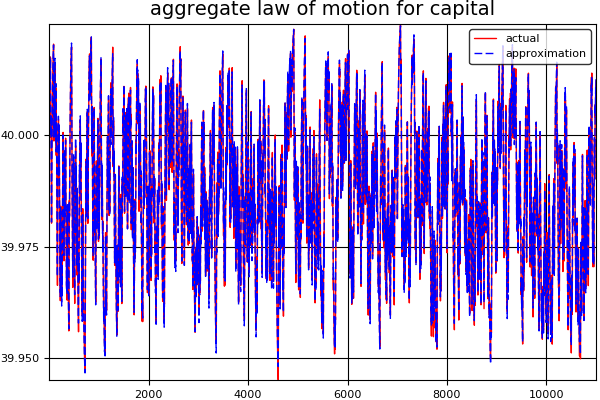

In [12]:
plot_ALM(ksp.z_grid,z_shocks,
         kss.B,K_ts)

In [16]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.1720118870948385+0.95337859998669log(K_{t}) in good time (R2 = 0.9998747700228053)
log(K_{t+1})=0.15650670455370946+0.9575564827328717log(K_{t}) in bad time (R2 = 0.9997377978109944)


In [14]:
save("result.jld","kss",kss)